In [ ]:
import torch
import torchvision
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils as utils
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import math
import copy
from ipynb.fs.full.FID import calculate_fretchet

# Seed
torch.manual_seed(42)

/home/nananda/.conda/envs/ece8550/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/home/nananda/.conda/envs/ece8550/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- H100/A100 Optimizations ---
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
torch.backends.cudnn.benchmark = True 

# Hyperparameters
learning_rate = 2e-4 
# Batch Size 512 is highly efficient and stable on A100
BATCH_SIZE = 512  
image_size = 64
channels_img = 3  
max_epochs = 350

base_channels = 64 

# DDPM Specifics
NOISE_STEPS = 1000
BETA_START = 0.0001
BETA_END = 0.02

# Data Loading
dataset = datasets.CIFAR10(root="./dataset/CIFAR10", download=True,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=16, pin_memory=True)

Files already downloaded and verified


In [ ]:
class DiffusionUtils:
    def __init__(self, noise_steps=1000, beta_start=1e-4, beta_end=0.02, img_size=64, device="cuda", schedule_name="linear"):
        self.noise_steps = noise_steps
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.img_size = img_size
        self.device = device
        self.schedule_name = schedule_name
        
        self.beta = self.prepare_noise_schedule().to(device)
        self.alpha = 1. - self.beta
        self.alpha_hat = torch.cumprod(self.alpha, dim=0)
        
    def prepare_noise_schedule(self):
        if self.schedule_name == "linear":
            return torch.linspace(self.beta_start, self.beta_end, self.noise_steps)
        elif self.schedule_name == "cosine":
            steps = self.noise_steps + 1
            x = torch.linspace(0, self.noise_steps, steps)
            alphas_cumprod = torch.cos(((x / self.noise_steps) + 0.008) / (1 + 0.008) * math.pi * 0.5) ** 2
            alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
            betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
            return torch.clip(betas, 0.0001, 0.9999)
        else:
            raise NotImplementedError(f"Unknown schedule: {self.schedule_name}")
    
    def noise_images(self, x, t):
        sqrt_alpha_hat = torch.sqrt(self.alpha_hat[t])[:, None, None, None]
        sqrt_one_minus_alpha_hat = torch.sqrt(1 - self.alpha_hat[t])[:, None, None, None]
        e = torch.randn_like(x)
        return sqrt_alpha_hat * x + sqrt_one_minus_alpha_hat * e, e

    def sample_timesteps(self, n):
        return torch.randint(low=1, high=self.noise_steps, size=(n,))

In [4]:
# Cell 4: Optimized U-Net (Attention only at low resolutions)

class EMA:
    def __init__(self, beta=0.995):
        self.beta = beta
        self.step = 0

    def update_model_average(self, ma_model, current_model):
        for current_params, ma_params in zip(current_model.parameters(), ma_model.parameters()):
            old_weight, up_weight = ma_params.data, current_params.data
            ma_params.data = self.update_average(old_weight, up_weight)

    def update_average(self, old, new):
        if old is None:
            return new
        return old * self.beta + (1 - self.beta) * new

    def step_ema(self, ema_model, model):
        self.step += 1
        self.update_model_average(ema_model, model)
        
    def reset_parameters(self, ema_model, model):
        ema_model.load_state_dict(model.state_dict())

class SelfAttention(nn.Module):
    def __init__(self, channels, size):
        super(SelfAttention, self).__init__()
        self.channels = channels
        self.size = size
        self.mha = nn.MultiheadAttention(channels, 4, batch_first=True)
        self.ln = nn.LayerNorm([channels])
        self.ff_self = nn.Sequential(
            nn.LayerNorm([channels]),
            nn.Linear(channels, channels),
            nn.GELU(),
            nn.Linear(channels, channels),
        )

    def forward(self, x):
        x = x.view(-1, self.channels, self.size * self.size).swapaxes(1, 2)
        x_ln = self.ln(x)
        attention_value, _ = self.mha(x_ln, x_ln, x_ln)
        attention_value = attention_value + x
        attention_value = self.ff_self(attention_value) + attention_value
        return attention_value.swapaxes(2, 1).view(-1, self.channels, self.size, self.size)

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None, residual=False):
        super().__init__()
        self.residual = residual
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, mid_channels),
            nn.SiLU(),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, out_channels),
        )

    def forward(self, x):
        if self.residual:
            return F.silu(x + self.double_conv(x))
        else:
            return self.double_conv(x)

class Down(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=256):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, in_channels, residual=True),
            DoubleConv(in_channels, out_channels),
        )
        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(emb_dim, out_channels),
        )

    def forward(self, x, t):
        x = self.maxpool_conv(x)
        emb = self.emb_layer(t)[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1])
        return x + emb

class Up(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=256):
        super().__init__()
        self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.conv = nn.Sequential(
            DoubleConv(in_channels, in_channels, residual=True),
            DoubleConv(in_channels, out_channels, in_channels // 2),
        )
        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(emb_dim, out_channels),
        )

    def forward(self, x, skip_x, t):
        x = self.up(x)
        x = torch.cat([skip_x, x], dim=1)
        x = self.conv(x)
        emb = self.emb_layer(t)[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1])
        return x + emb

class UNet(nn.Module):
    def __init__(self, c_in=3, c_out=3, time_dim=256, base_c=64, device="cuda"):
        super().__init__()
        self.device = device
        self.time_dim = time_dim
        self.inc = DoubleConv(c_in, 64)
        
        # Downsampling
        self.down1 = Down(64, 128) 
        # REMOVED 32x32 Attention (Too expensive)
        self.down2 = Down(128, 256)
        self.sa2 = SelfAttention(256, 16) # Keep 16x16
        self.down3 = Down(256, 256)
        self.sa3 = SelfAttention(256, 8)  # Keep 8x8

        # Bottleneck
        self.bot1 = DoubleConv(256, 512)
        self.bot2 = DoubleConv(512, 512)
        self.bot3 = DoubleConv(512, 256)

        # Upsampling
        self.up1 = Up(512, 128)
        self.sa4 = SelfAttention(128, 16) # Keep 16x16
        self.up2 = Up(256, 64)
        # REMOVED 32x32 Attention
        self.up3 = Up(128, 64)
        # REMOVED 64x64 Attention (CRITICAL FIX)
        
        self.outc = nn.Conv2d(64, c_out, kernel_size=1)

    def pos_encoding(self, t, channels):
        inv_freq = 1.0 / (
            10000
            ** (torch.arange(0, channels, 2, device=self.device).float() / channels)
        )
        pos_enc_a = torch.sin(t.repeat(1, channels // 2) * inv_freq)
        pos_enc_b = torch.cos(t.repeat(1, channels // 2) * inv_freq)
        pos_enc = torch.cat([pos_enc_a, pos_enc_b], dim=-1)
        return pos_enc

    def forward(self, x, t):
        t = t.unsqueeze(-1).type(torch.float)
        t = self.pos_encoding(t, self.time_dim)

        x1 = self.inc(x)
        
        # Down
        x2 = self.down1(x1, t) # 32x32
        x3 = self.down2(x2, t) # 16x16
        x3 = self.sa2(x3)
        x4 = self.down3(x3, t) # 8x8
        x4 = self.sa3(x4)

        # Bot
        x4 = self.bot1(x4)
        x4 = self.bot2(x4)
        x4 = self.bot3(x4)

        # Up
        x = self.up1(x4, x3, t) # 16x16
        x = self.sa4(x)
        x = self.up2(x, x2, t) # 32x32
        x = self.up3(x, x1, t) # 64x64
        
        return self.outc(x)

In [5]:
# Cell 5: Initialization

# Initialize Models
model = UNet(base_c=base_channels, device=device).to(device)

# EMA Model (Shadow copy)
ema_model = UNet(base_c=base_channels, device=device).to(device)

ema = EMA(0.995)
ema.reset_parameters(ema_model, model) 

diffusion = DiffusionUtils(img_size=image_size, device=device)
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
mse = nn.MSELoss()

LossList = []
FID_list = []
best_fid = float('inf')
best_fake_images = None

In [ ]:
def sample_images(model, diffusion, n):
    model.eval()
    with torch.no_grad():
        x = torch.randn((n, 3, diffusion.img_size, diffusion.img_size)).to(device)
        
        for i in reversed(range(1, diffusion.noise_steps)):
            t = (torch.ones(n) * i).long().to(device)
            
            # Used bfloat16 for inference speed too
            with torch.autocast(device_type="cuda", dtype=torch.bfloat16):
                predicted_noise = model(x, t)
            
            alpha = diffusion.alpha[t][:, None, None, None]
            alpha_hat = diffusion.alpha_hat[t][:, None, None, None]
            beta = diffusion.beta[t][:, None, None, None]
            
            if i > 1:
                noise = torch.randn_like(x)
            else:
                noise = torch.zeros_like(x)
            
            x = (1 / torch.sqrt(alpha)) * (x - ((1 - alpha) / (torch.sqrt(1 - alpha_hat))) * predicted_noise) + torch.sqrt(beta) * noise
            
    model.train()
    x = (x.clamp(-1, 1) + 1) / 2 
    x = (x * 255).type(torch.uint8)
    return x

In [ ]:
from torch.nn.utils import clip_grad_norm_

print("Starting Advanced Training (A100 + BFloat16 + EMA)...")

for epoch in range(max_epochs):
    epoch_loss = 0
    model.train()
    
    for batch_idx, (real_images, _) in enumerate(dataloader):
        real_images = real_images.to(device)
        t = diffusion.sample_timesteps(real_images.shape[0]).to(device)
        x_t, noise = diffusion.noise_images(real_images, t)
        
        optimizer.zero_grad()
        
        # --- BFloat16 Mixed Precision ---
        # A100 supports this natively. It prevents the NaNs with float16.
        with torch.autocast(device_type="cuda", dtype=torch.bfloat16):
            predicted_noise = model(x_t, t)
            loss = mse(noise, predicted_noise)
        
        loss.backward()
        
        # Gradient Clipping (Safety net)
        clip_grad_norm_(model.parameters(), 1.0)
        
        optimizer.step()
        
        # Update EMA model
        ema.step_ema(ema_model, model)
        
        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(dataloader)
    LossList.append(avg_loss)
    
    # --- Evaluation with EMA Model ---
    if (epoch + 1) % 20 == 0: # Evaluate every 20 epochs to save time
        # Sample from EMA model (better quality)
        fake_images_uint8 = sample_images(ema_model, diffusion, n=BATCH_SIZE)
        
        # Real images for FID
        real_images_uint8 = (real_images * 0.5 + 0.5).clamp(0, 1) * 255
        real_images_uint8 = real_images_uint8.type(torch.uint8)
        
        real_fid_input = real_images_uint8.float() / 255.0
        fake_fid_input = fake_images_uint8.float() / 255.0
        
        try:
            fid_score = calculate_fretchet(real_fid_input, fake_fid_input)
        except Exception as e:
            print(f"FID Error: {e}")
            fid_score = 999.0
            
        FID_list.append(fid_score)
        
        if fid_score < best_fid:
            best_fid = fid_score
            best_fake_images = fake_images_uint8.clone()
            
        print(f"Epoch [{epoch+1}/{max_epochs}] | Loss: {avg_loss:.5f} | EMA FID: {fid_score:.3f}")
    else:
        print(f"Epoch [{epoch+1}/{max_epochs}] | Loss: {avg_loss:.5f}")

Starting Advanced Training (A100 + BFloat16 + EMA)...
Epoch [1/350] | Loss: 0.16858
Epoch [2/350] | Loss: 0.04601
Epoch [3/350] | Loss: 0.03046
Epoch [4/350] | Loss: 0.02399
Epoch [5/350] | Loss: 0.02171
Epoch [6/350] | Loss: 0.01951
Epoch [7/350] | Loss: 0.01851
Epoch [8/350] | Loss: 0.01742
Epoch [9/350] | Loss: 0.01692
Epoch [10/350] | Loss: 0.01643
Epoch [11/350] | Loss: 0.01578
Epoch [12/350] | Loss: 0.01541
Epoch [13/350] | Loss: 0.01484
Epoch [14/350] | Loss: 0.01462
Epoch [15/350] | Loss: 0.01432
Epoch [16/350] | Loss: 0.01410
Epoch [17/350] | Loss: 0.01384
Epoch [18/350] | Loss: 0.01372
Epoch [19/350] | Loss: 0.01361
Epoch [20/350] | Loss: 0.01327 | EMA FID: 138.563
Epoch [21/350] | Loss: 0.01311
Epoch [22/350] | Loss: 0.01303
Epoch [23/350] | Loss: 0.01300
Epoch [24/350] | Loss: 0.01296
Epoch [25/350] | Loss: 0.01253
Epoch [26/350] | Loss: 0.01278
Epoch [27/350] | Loss: 0.01254
Epoch [28/350] | Loss: 0.01237
Epoch [29/350] | Loss: 0.01232
Epoch [30/350] | Loss: 0.01251
Epoch 

KeyboardInterrupt: 

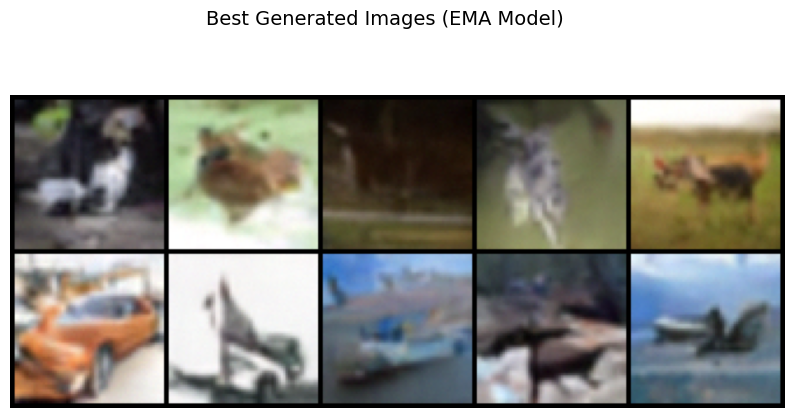

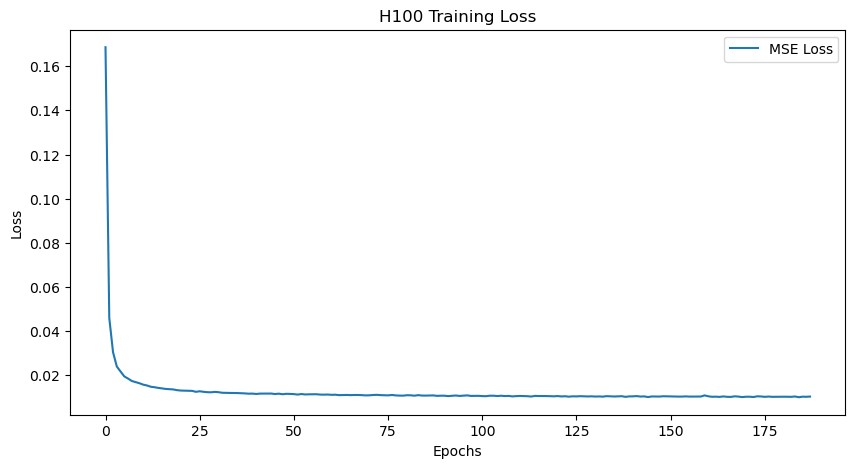

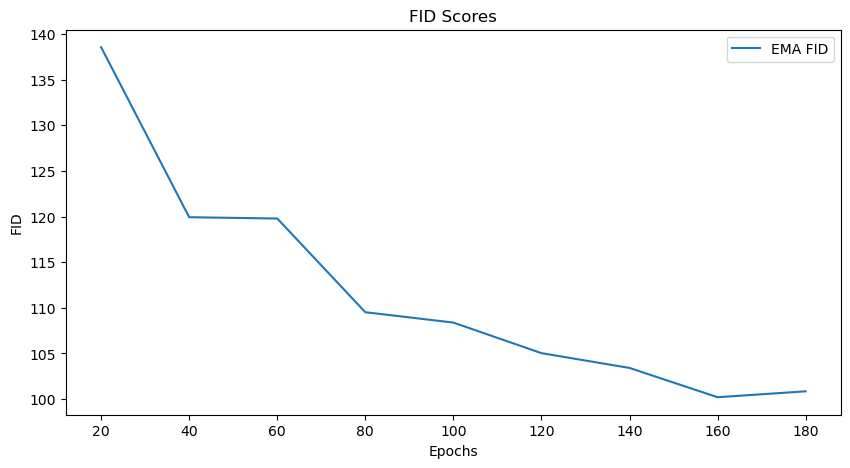

In [8]:
# Display the best generated images
if best_fake_images is not None:
    plt.figure(figsize=(10, 5))
    plt.suptitle("Best Generated Images (EMA Model)", fontsize=14)
    # Convert back to float [0,1] for matplotlib
    show_imgs = best_fake_images[:10].float() / 255.0
    grid = utils.make_grid(show_imgs, nrow=5, normalize=False)
    plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
    plt.axis("off")
    plt.show()       

# Plot Loss
plt.figure(figsize=(10,5))
plt.title("H100 Training Loss")
plt.plot(LossList, label="MSE Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.savefig('DDPM_LOSS.pdf', format='pdf', bbox_inches='tight')
plt.show()

# Plot FID
plt.figure(figsize=(10,5))
plt.title("FID Scores")

# FIX: Changed step size from 10 -> 20 to match your new training loop
x_epochs = range(20, len(FID_list)*20 + 1, 20)

plt.plot(x_epochs, FID_list, label="EMA FID")
plt.xlabel("Epochs")
plt.ylabel("FID")
plt.legend()
plt.savefig('DDPM_FID.pdf', format='pdf', bbox_inches='tight')
plt.show()

# Save Data
np.save('DDPM_FID', FID_list)
np.save('DDPM_LOSS', LossList)